In [1173]:
## ECE 397 - Individual Study in ECE Problems
## Professor: Thomas Moon
## Student: Jihyun Seo

## This program uses an SDR device to transmit and receive datas encoded in PPM (Pulse Positioning Modulation)
## The Bits are converted into PPM modulated Symbols, and will be transmitted through channel.
## Processing through essential wireless communication stages.

## Objective:
## The goal is to successfully transmit bits using PPM modulation, 
## by performing these core wireless communication functions.

In [1174]:
import numpy as np
import matplotlib.pyplot as plt 
import adi
from scipy import signal
from scipy.signal import upfirdn


######################### Set up PlutoSDR Tx and Rx ######################## 
fs = 2e6  # Sampling rate (1 MHz) → 1 sample per 0.5 μs
chip_duration = 0.5e-6  # 0.5 μs per chip
samples_per_chip = max(1,int(fs * chip_duration))  # 1 sample per c
sps = 8  # Increase resolution by 8x
carrier_freq = 1090e6 # carrier frequency of 1090 MHZ


# Transmit settings
sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = int(fs)

# Config Tx
# filter cutoff, just set it to the same as sample rate, valid range is 200 kHz to 20 MHz
sdr.tx_rf_bandwidth = int(fs) 
# set carrier frequency, valid range is 380 MHz to 3.8GHz
sdr.tx_lo = int(carrier_freq)
# set tx power, valid range is -90 to 0 dB
sdr.tx_hardwaregain_chan0 = -5

# Config Rx
sdr.rx_lo = int(carrier_freq)
sdr.rx_rf_bandwidth = int(fs)
sdr.rx_buffer_size = 128
sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0 = 15.0




In [1175]:
# Parameters





# Step 1: Define the preamble (in chips) → 8us duration. Each chips takes 0.5us duration.
# 0 μs
# 1 μs
# 3.5 μs
# 4.5 μs
# With a total preamble length of 8 microsecond.
preamble_chips = np.array([1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0])






# Step 2: Generate a random 100-bit sequence
num_bits = 10
bit_sequence = np.random.randint(0, 2, num_bits)







# Step 3: Convert bits to chips (1 → [1, 0], 0 → [0, 1])
def bits_to_chips(bits):
    chips = np.zeros(len(bits) * 2, dtype=int)
    for i, bit in enumerate(bits):
        if bit == 1:
            chips[i * 2: i * 2 + 2] = [1, 0]  # 1 → [10]
        else:
            chips[i * 2: i * 2 + 2] = [0, 1]  # 0 → [01]
    return chips


chip_sequence = bits_to_chips(bit_sequence)








# Step 4: Concatenate preamble and chip sequence
tx_signal_chips = np.concatenate([preamble_chips, chip_sequence])


print("chip-sequence of data packet : " , chip_sequence)
print("ADS-B Packet at Tx: " ,tx_signal_chips)

chip-sequence of data packet :  [1 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 0]
ADS-B Packet at Tx:  [1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 0]


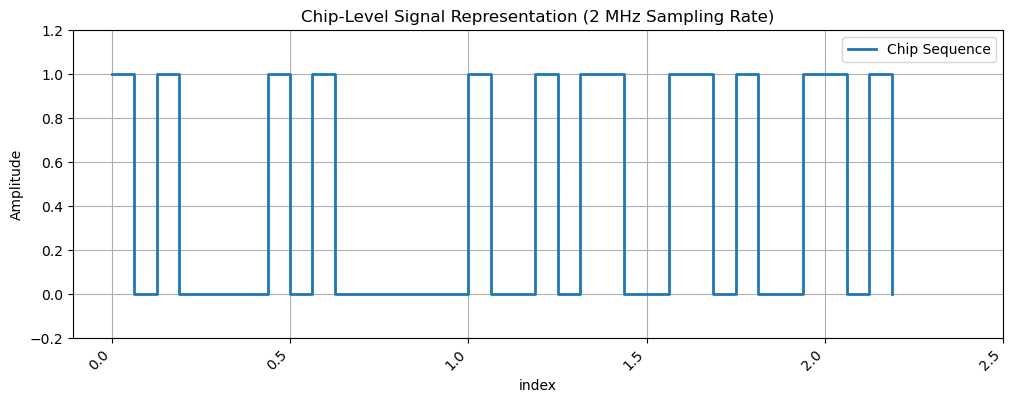

In [1230]:
# Plotting
n_show = min(40, len(tx_signal_chips))
plt.figure(figsize=(12, 4))
plt.step(time_axis_us[:n_show], tx_signal_chips[:n_show], where='post', label="Chip Sequence", linewidth=2)

# Set x-ticks every 0.5 µs
max_time = time_axis_us[n_show - 1]
plt.xticks(np.arange(0, max_time + 0.5, 0.5))

plt.title("Chip-Level Signal Representation (2 MHz Sampling Rate)")
plt.xlabel("index")
plt.ylabel("Amplitude")
plt.ylim(-0.2, 1.2)
plt.legend()
plt.grid()
plt.xticks(rotation=45, ha='right')
plt.show()

In [1177]:
#############  Step 6: Upsample the full frame by sps (insert sps-1 zeros between each symbol)
up_sym = np.zeros(len(tx_signal_chips) * sps, dtype = complex)  # Create an array of zeros
up_sym[::sps] = tx_signal_chips  # Insert symbols into every sps-th position
#print(len(up_sym)) = 336  = 42 * 8 = symbols * samples (upsampling factor)



In [1178]:
############# Define RRC Filter ###################

def rrcosfilter(N, alpha, Ts, Fs):
    """
    Generates a root raised cosine (RRC) filter (FIR) impulse response.

    Parameters
    ----------
    N : int
        Length of the filter in samples.

    alpha : float
        Roll off factor (Valid values are [0, 1]).

    Ts : float
        Symbol period in seconds.

    Fs : float
        Sampling Rate in Hz.

    Returns
    ---------

    time_idx : 1-D ndarray of floats
        Array containing the time indices, in seconds, for
        the impulse response.

    h_rrc : 1-D ndarray of floats
        Impulse response of the root raised cosine filter.
    """

    T_delta = 1/float(Fs)
    time_idx = ((np.arange(N)-N/2))*T_delta
    sample_num = np.arange(N)
    h_rrc = np.zeros(N, dtype=float)

    for x in sample_num:
        t = (x-N/2)*T_delta
        if t == 0.0:
            h_rrc[x] = 1.0 - alpha + (4*alpha/np.pi)
        elif alpha != 0 and t == Ts/(4*alpha):
            h_rrc[x] = (alpha/np.sqrt(2))*(((1+2/np.pi)* \
                    (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        elif alpha != 0 and t == -Ts/(4*alpha):
            h_rrc[x] = (alpha/np.sqrt(2))*(((1+2/np.pi)* \
                    (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        else:
            h_rrc[x] = (np.sin(np.pi*t*(1-alpha)/Ts) +  \
                    4*alpha*(t/Ts)*np.cos(np.pi*t*(1+alpha)/Ts))/ \
                    (np.pi*t*(1-(4*alpha*t/Ts)*(4*alpha*t/Ts))/Ts)

    return time_idx, h_rrc



##################### Corrected part as of Oct 2nd ####################################
#len(frame) = 42 = len(barker) + len(guard) + len(symbols) = 13 + 13 + 16

N = len(tx_signal_chips) * sps   # Filter length in terms of samples per symbol = length of upsampled symbol for frame
alpha = 1  # Roll-off factor 
f_sym = fs/sps   # Symbol rate =  [fs] /[sps]  sampling rate / number of samples
                 # sampling rate = symbol_rate * number of samples ( symbol factor)

# Calculate Ts (symbol period) and Fs (sampling rate)
Ts = 1 / f_sym         # Symbol period in seconds (1 microsecond for 1 MHz)
Fs = sps * f_sym       # Sampling rate in Hz  = number of samples * symbol rate

time_idx, rrc_filter = rrcosfilter(N, alpha, Ts, Fs)

##################### Corrected part as of Oct 2nd ends ####################################

In [1179]:
# Pulse shaping by convolving upsampled symbols with RRC filter
your_Tx_samples = np.convolve(up_sym, rrc_filter, mode='same')


In [1180]:
############## Scale and transmit pulse-shaped samples #####################
tx_samples = your_Tx_samples * 2**14  # Scale for SDR transmission
sdr.tx_cyclic_buffer = True  # Enable continuous transmission
sdr.tx(tx_samples)



In [1181]:
###################### Receive samples #########################
sdr.rx_buffer_size = 2 * tx_samples.size  # Set buffer size for reception

# Clear the buffer to avoid stale data
for i in range(5):
    sdr.rx()  # Clear stale buffer data

# Receive the transmitted signal
rx_samples_raw = sdr.rx()
rx_samples = rx_samples_raw * 2**-14  # Scale received samples back down

# Stop transmitting
sdr.tx_destroy_buffer()



#########################   Apply matched filtering using the same RRC filter ########################  
rx_matched = np.convolve(rx_samples, rrc_filter, mode='same')

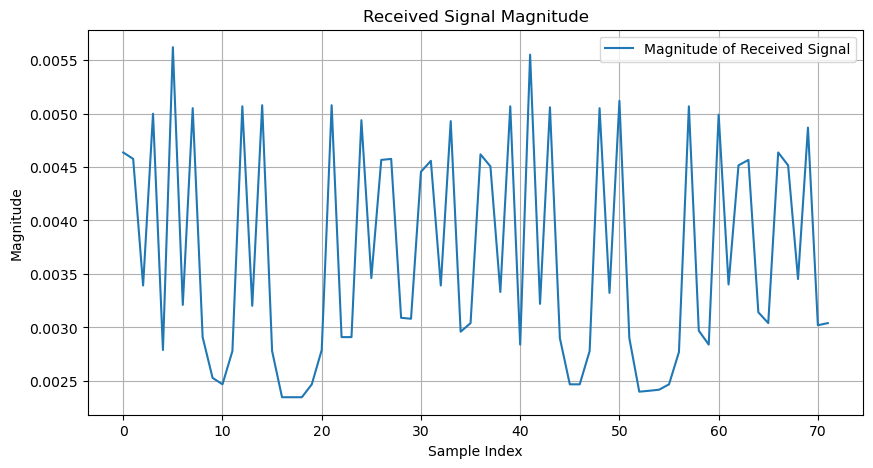

In [1182]:
######################### Time recovery for rx_matched ######################## 


# Maximum energy approach for symbol timing recovery
energy = np.zeros(sps)

# Compute the energy across different offsets
for k in range(sps):
    # Take every sps-th sample starting from the k-th sample and compute energy
    energy[k] = np.sum(np.abs(rx_samples[k::sps])**2)  # Sum of squared magnitudes

# Find the offset that maximizes the energy
max_ind = np.argmax(energy)

# Align the samples using the offset with the maximum energy
rx_align = rx_samples[max_ind:] 


# covnert align to symbol
##################################################################################################  

############ Downsampling (Must be done after Time recovery but before frame synch) to covnert samples to symbols ####################

rx_align_symbol = rx_align[::sps]

# Not doing downsampling
#rx_align_symbol = rx_align


# Compute magnitude of the received signal
rx_magnitude = np.abs(rx_align_symbol)

# Plot the magnitude of the received samples
plt.figure(figsize=(10, 5))
plt.plot(rx_magnitude, label="Magnitude of Received Signal")
plt.xlabel("Sample Index")
plt.ylabel("Magnitude")
plt.title("Received Signal Magnitude")
plt.legend()
plt.grid(True)
plt.show()



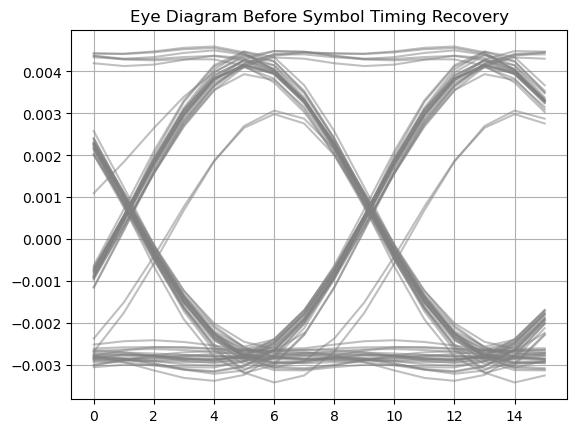

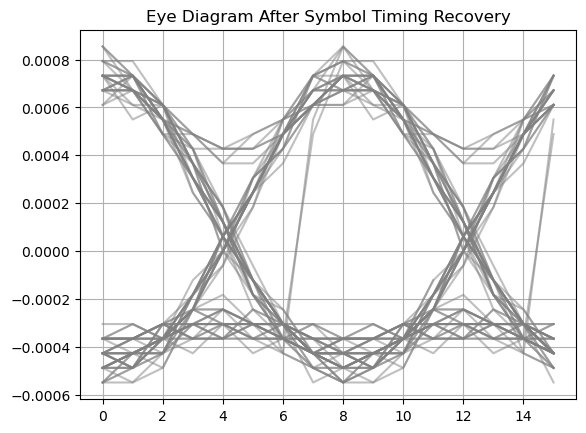

In [1183]:
# Eye Diagram for rx_matched (before timing recovery)
plt.figure()
for k in range(len(rx_matched) // sps):
    plt.plot(rx_matched[k * sps:(k + 2) * sps], color='gray', alpha=0.5)
plt.title('Eye Diagram Before Symbol Timing Recovery')
plt.grid(True)
plt.show()

# Eye Diagram for rx_align (after timing recovery)
plt.figure()
for k in range(len(rx_align) // sps):
    plt.plot(rx_align[k * sps:(k + 2) * sps], color='gray', alpha=0.5)
plt.title('Eye Diagram After Symbol Timing Recovery')
plt.grid(True)
plt.show()


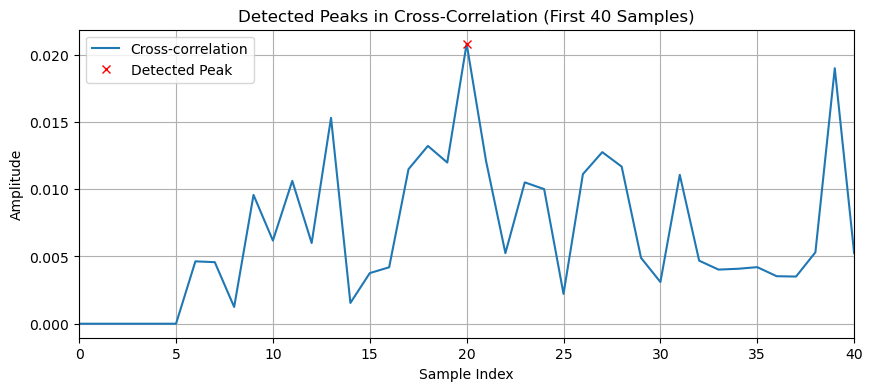

Start index of data symbols: 21
Peak index of detected preamble: 20


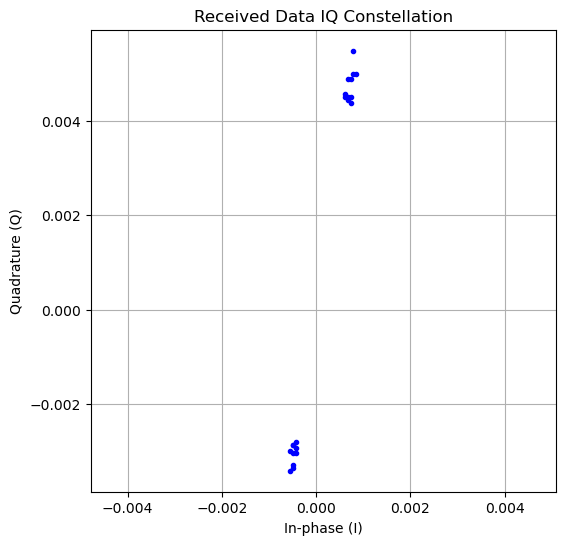

In [1184]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

############################# Step 1: Compute Cross-Correlation ############################
cross_corr = np.abs(np.convolve(rx_align_symbol, preamble_chips[::-1], mode='full'))

############################# Step 2: Find Peaks in the First 40 Samples ############################
search_range = cross_corr[:40]  # Limit search range to the first 40 samples

# Find peaks within this range
peaks, properties = find_peaks(search_range, height=0.01)  # Adjusted height if needed

# Find the highest peak within this range
if len(peaks) > 0:
    peak_index = peaks[np.argmax(properties["peak_heights"])]  # Select the highest peak in the first 40 samples
else:
    peak_index = None
    print("No peaks detected in the first 40 samples!")

# Plot cross-correlation with detected peak
plt.figure(figsize=(10, 4))
plt.plot(cross_corr, label='Cross-correlation')

if peak_index is not None:
    plt.plot(peak_index, cross_corr[peak_index], 'rx', label='Detected Peak')

plt.title('Detected Peaks in Cross-Correlation (First 40 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.xlim(0, 40)  # Limit x-axis to first 40 samples
plt.grid(True)
plt.legend()
plt.show()

#################### Step 3: Frame Synchronization ####################
if peak_index is not None:
    start_index = peak_index + 1  # Ensure correct indexing
    print(f"Start index of data symbols: {start_index}")
    print(f"Peak index of detected preamble: {peak_index}")

    # Extract the data symbols
    num_symbols = len(chip_sequence)
    rx_data = rx_align_symbol[start_index : start_index + num_symbols + 1]

    #################### Step 4: Plot IQ Constellation ####################
    plt.figure(figsize=(6, 6))
    plt.plot(rx_data.real, rx_data.imag, '.', color='blue')  # Plot I vs Q components
    plt.xlabel('In-phase (I)')
    plt.ylabel('Quadrature (Q)')
    plt.title('Received Data IQ Constellation')
    plt.grid(True)

    # Ensure equal aspect ratio for clarity
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='datalim')
    plt.show()
else:
    print("Synchronization failed. Check the signal quality and preamble correlation.")


In [1185]:
# Find out the frame, then split it into preamble and data 
N = len(chip_sequence)
P = len(preamble_chips)
rx_frame = rx_align_symbol[start_index - P : start_index + N ]
rx_preamble = rx_frame[: start_index - 1]
rx_data = rx_align_symbol[start_index:start_index + N]  # Data symbols after preamble and guard band



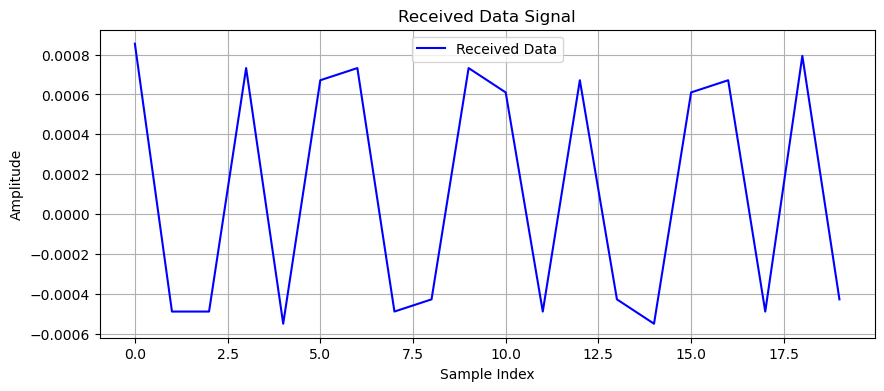

In [1186]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure start_index is valid
if start_index is not None and start_index + N <= len(rx_align_symbol):
    rx_data = rx_align_symbol[start_index:start_index + N]  # Extract data symbols

    # Plot the received data
    plt.figure(figsize=(10, 4))
    plt.plot(rx_data, label='Received Data', color='blue', linewidth=1.5)
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.title('Received Data Signal')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("Invalid start_index or N value. Ensure proper synchronization before extracting rx_data.")


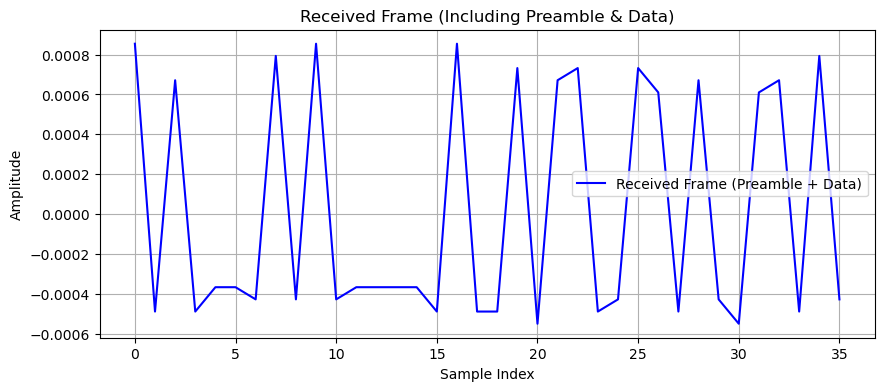

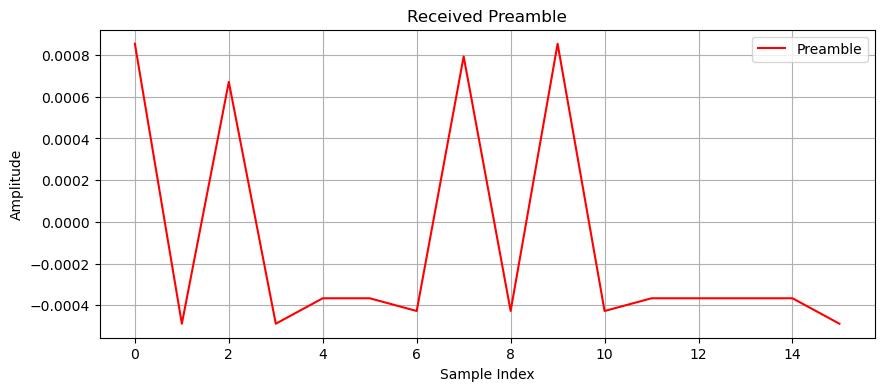

In [1187]:
import matplotlib.pyplot as plt

# Ensure start_index is valid
if start_index is not None and start_index + N <= len(rx_align_symbol):
    # Extract frame, preamble, and data
    rx_frame = rx_align_symbol[start_index - P : start_index + N]  # Complete frame (preamble + data)
    rx_preamble = rx_frame[:P]  # Extract only the preamble

    # Plot rx_frame
    plt.figure(figsize=(10, 4))
    plt.plot(rx_frame, label='Received Frame (Preamble + Data)', color='blue', linewidth=1.5)
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.title('Received Frame (Including Preamble & Data)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot rx_preamble
    plt.figure(figsize=(10, 4))
    plt.plot(rx_preamble, label='Preamble', color='red', linewidth=1.5)
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.title('Received Preamble')
    plt.grid(True)
    plt.legend()
    plt.show()
    
else:
    print("Invalid start_index or N value. Ensure proper synchronization before extracting rx_frame and rx_preamble.")


In [1188]:
import numpy as np

# Extract received preamble
rx_preamble = rx_align_symbol[start_index - P : start_index]

# Estimate CFO using phase difference
phase_diffs = np.angle(rx_preamble[1:] * np.conj(rx_preamble[:-1]))
estimated_CFO = np.mean(phase_diffs) / (2 * np.pi)  # Normalized frequency offset

print(f"Estimated CFO: {estimated_CFO} Hz")

# Correct CFO: Apply frequency de-rotation
n = np.arange(len(rx_align_symbol))
cfo_correction = np.exp(-1j * 2 * np.pi * estimated_CFO * n)
rx_corrected = rx_align_symbol * cfo_correction  # Apply correction

# Verify corrected signal
rx_preamble_corrected = rx_corrected[start_index - P : start_index]
rx_data_corrected = rx_corrected[start_index : start_index + N]


Estimated CFO: 0.033086215606483865 Hz


In [1189]:
#Step 12 : Channel Estimation

def estimate_h(rx_preamble, tx_preamble, L):
    """
    Estimate the channel response h.

    Parameters
    ----------
    rx_preamble : 1-D ndarray of complex floats
        The received preamble.

    tx_preamble : 1-D ndarray of floats
        The original preamble sent from Tx.

    L : int
        The length of the channel.

    Returns
    -------
    hhat : 1-D ndarray of complex floats
        The estimated channel (in time-domain).
    """
    N = tx_preamble.size
    A = np.zeros((N - L + 1, L), dtype=complex)
    
    # Build the matrix A using delayed versions of the Tx preamble
    for k in range(N - L + 1):
        A[k, :] = np.flip(tx_preamble[k:k+L])
    
    # Received preamble symbols for estimation
    y = rx_preamble[L-1:N]
    
    # Least Squares solution to estimate the channel
    hhat = np.linalg.lstsq(A, y, rcond=None)[0]
    
    return hhat


############ YOUR CODE ENDS HERE ############
# Step 12-1: Estimate the channel using the preamble  
L = 1
tx_preamble = preamble_chips
hhat = estimate_h(rx_preamble_corrected, tx_preamble, L)
    
# Step 12-2: Correct channel by simple division
rx_data_corrected_afterChannelEQ = rx_data_corrected / hhat  # Apply the inverse of the estimated channel





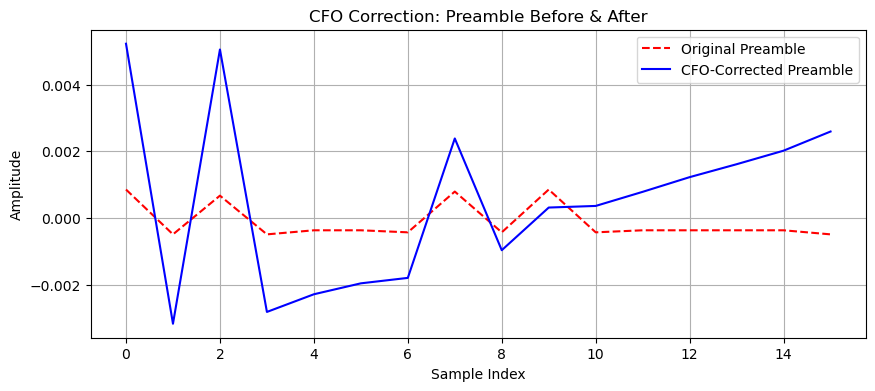

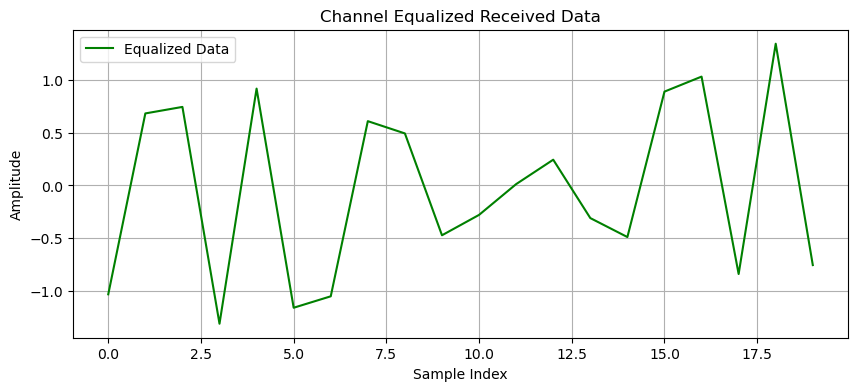

In [1190]:
import matplotlib.pyplot as plt
import numpy as np

# Plot CFO Correction: Original vs. Corrected Preamble
plt.figure(figsize=(10, 4))
plt.plot(np.real(rx_preamble), label="Original Preamble", linestyle="dashed", color='red')
plt.plot(np.real(rx_preamble_corrected), label="CFO-Corrected Preamble", color='blue')
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.title("CFO Correction: Preamble Before & After")
plt.legend()
plt.grid(True)
plt.show()

# Plot Channel Equalized Data
plt.figure(figsize=(10, 4))
plt.plot(np.real(rx_data_corrected_afterChannelEQ), label="Equalized Data", color='green')  # FIXED PARENTHESES
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.title("Channel Equalized Received Data")
plt.legend()
plt.grid(True)
plt.show()


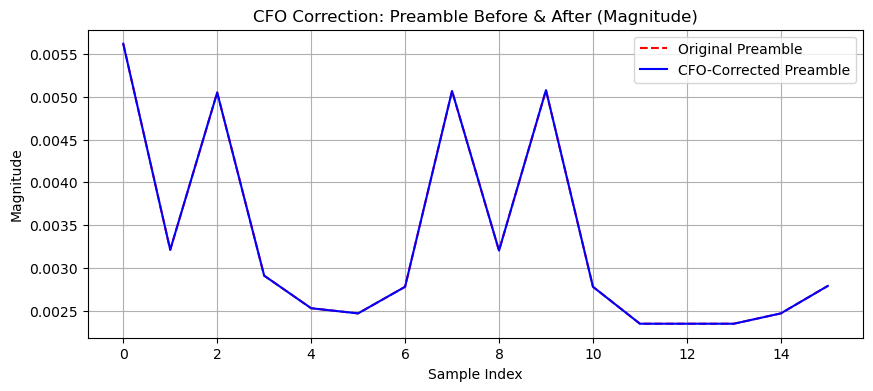

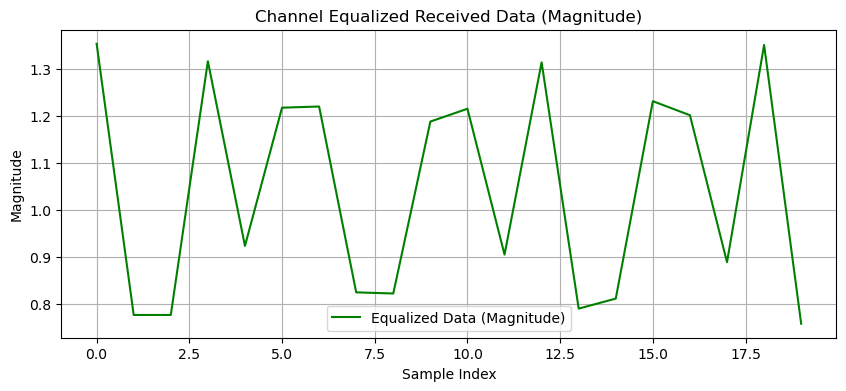

In [1191]:
import matplotlib.pyplot as plt
import numpy as np

# Plot CFO Correction: Original vs. Corrected Preamble
plt.figure(figsize=(10, 4))
plt.plot(np.abs(rx_preamble), label="Original Preamble", linestyle="dashed", color='red')
plt.plot(np.abs(rx_preamble_corrected), label="CFO-Corrected Preamble", color='blue')
plt.xlabel("Sample Index")
plt.ylabel("Magnitude")
plt.title("CFO Correction: Preamble Before & After (Magnitude)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Channel Equalized Data (Magnitude)
plt.figure(figsize=(10, 4))
plt.plot(np.abs(rx_data_corrected_afterChannelEQ), label="Equalized Data (Magnitude)", color='green')
plt.xlabel("Sample Index")
plt.ylabel("Magnitude")
plt.title("Channel Equalized Received Data (Magnitude)")
plt.legend()
plt.grid(True)
plt.show()


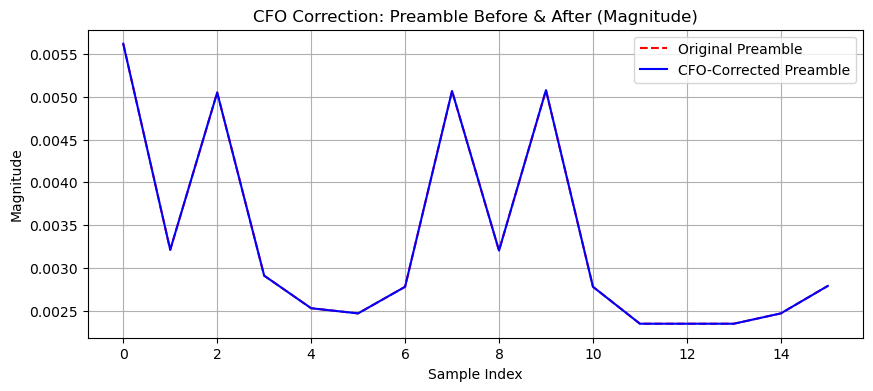

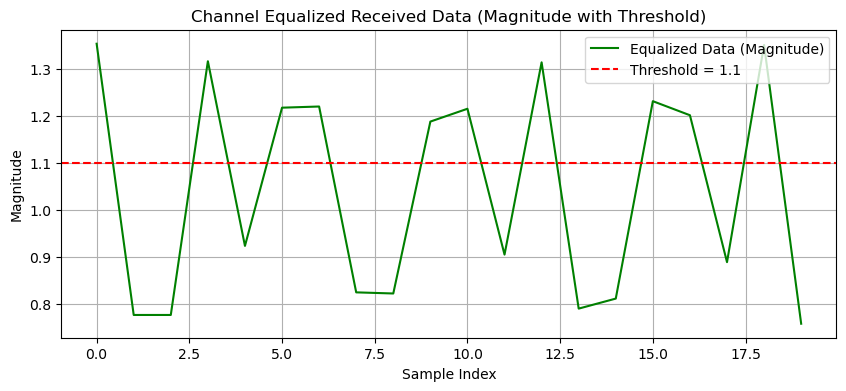

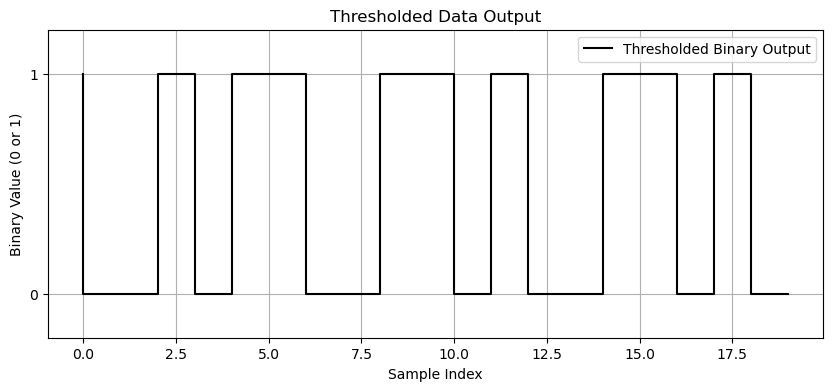

In [1192]:
import matplotlib.pyplot as plt
import numpy as np

# Apply thresholding to magnitude
rx_data_magnitude = np.abs(rx_data_corrected_afterChannelEQ)

# Threshold function
rx_data_thresholded = np.where(rx_data_magnitude >= 1.1, 1, 0)

# Plot CFO Correction: Original vs. Corrected Preamble
plt.figure(figsize=(10, 4))
plt.plot(np.abs(rx_preamble), label="Original Preamble", linestyle="dashed", color='red')
plt.plot(np.abs(rx_preamble_corrected), label="CFO-Corrected Preamble", color='blue')
plt.xlabel("Sample Index")
plt.ylabel("Magnitude")
plt.title("CFO Correction: Preamble Before & After (Magnitude)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Channel Equalized Data (Magnitude)
plt.figure(figsize=(10, 4))
plt.plot(rx_data_magnitude, label="Equalized Data (Magnitude)", color='green')
plt.axhline(y=1.1, color='red', linestyle='dashed', label="Threshold = 1.1")  # Threshold line
plt.xlabel("Sample Index")
plt.ylabel("Magnitude")
plt.title("Channel Equalized Received Data (Magnitude with Threshold)")
plt.legend()
plt.grid(True)
plt.show()

# Plot the Thresholded Binary Output
plt.figure(figsize=(10, 4))
plt.step(range(len(rx_data_thresholded)), rx_data_thresholded, label="Thresholded Binary Output", color='black', linewidth=1.5)
plt.xlabel("Sample Index")
plt.ylabel("Binary Value (0 or 1)")
plt.title("Thresholded Data Output")
plt.ylim(-0.2, 1.2)  # Keep the binary range clear
plt.yticks([0, 1])
plt.legend()
plt.grid(True)
plt.show()


In [1193]:
print("Demodulated bits using PPM:         " ,rx_data_thresholded)
print("Original Chip Sequence at Tx side : " ,chip_sequence)

Demodulated bits using PPM:          [1 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 0]
Original Chip Sequence at Tx side :  [1 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 0]


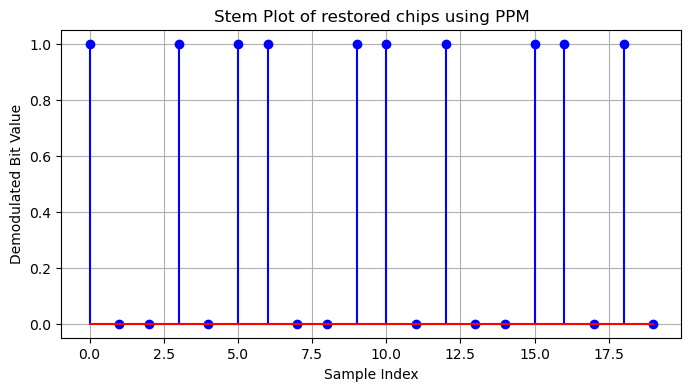

[1 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 0]


In [1228]:
# Create a stem plot
plt.figure(figsize=(8, 4))
plt.stem(rx_data_thresholded, linefmt='b-', markerfmt='bo', basefmt='r-')
plt.xlabel("Sample Index")
plt.ylabel("Demodulated Bit Value")
plt.title("Stem Plot of restored chips using PPM")
plt.grid(True)
plt.show()

print(rx_data_thresholded)

In [1222]:
# Function to decode chips to bits
def chips_to_bits(chips):
    bits = np.zeros(len(chips) // 2, dtype=int)
    for i in range(len(bits)):
        if chips[i * 2] == 1 and chips[i * 2 + 1] == 0:
            bits[i] = 1  # [10] → 1
        elif chips[i * 2] == 0 and chips[i * 2 + 1] == 1:
            bits[i] = 0  # [01] → 0
    return bits

# Decode rx_data_thresholded
binary_bits = chips_to_bits(rx_data_thresholded)

print("binary_bits_decoded at Rx: " , binary_bits)

binary_bits_decoded at Rx:  [1 0 0 1 0 1 1 0 1 1]


Decoded Bits:               [1 0 0 1 0 1 1 0 1 1]
Original Bit Sequence:      [1 0 0 1 0 1 1 0 1 1]
Match:                      True


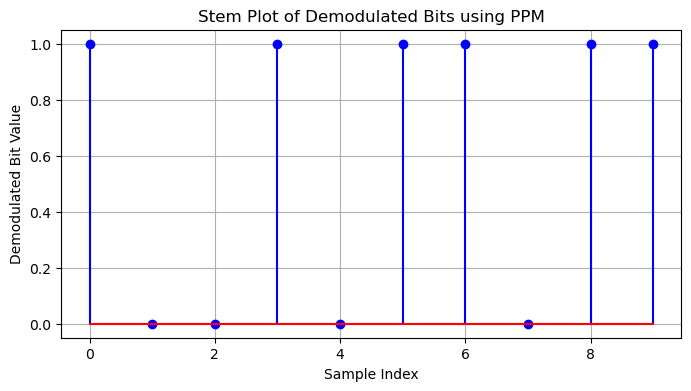

In [1226]:
# Compare with original bit sequence
comparison = (binary_bits == bit_sequence[:len(binary_bits)])
print("Decoded Bits:              ", binary_bits)
print("Original Bit Sequence:     ", bit_sequence)
print("Match:                     ", comparison.all())

# Create a stem plot
plt.figure(figsize=(8, 4))
plt.stem(binary_bits, linefmt='b-', markerfmt='bo', basefmt='r-')
plt.xlabel("Sample Index")
plt.ylabel("Demodulated Bit Value")
plt.title("Stem Plot of Demodulated Bits using PPM")
plt.grid(True)
plt.show()
